In [7]:
!pip install rasterio
!pip install GDAL

In [9]:
import rasterio
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from rasterio.windows import Window
from osgeo import gdal #Import gdal again after installing and restarting kernel

Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1067
           1       1.00      1.00      1.00      1516
           2       1.00      1.00      1.00      1427
           3       1.00      1.00      1.00      2244
           4       1.00      1.00      1.00      2359
           5       1.00      1.00      1.00      1827

    accuracy                           1.00     10440
   macro avg       1.00      1.00      1.00     10440
weighted avg       1.00      1.00      1.00     10440



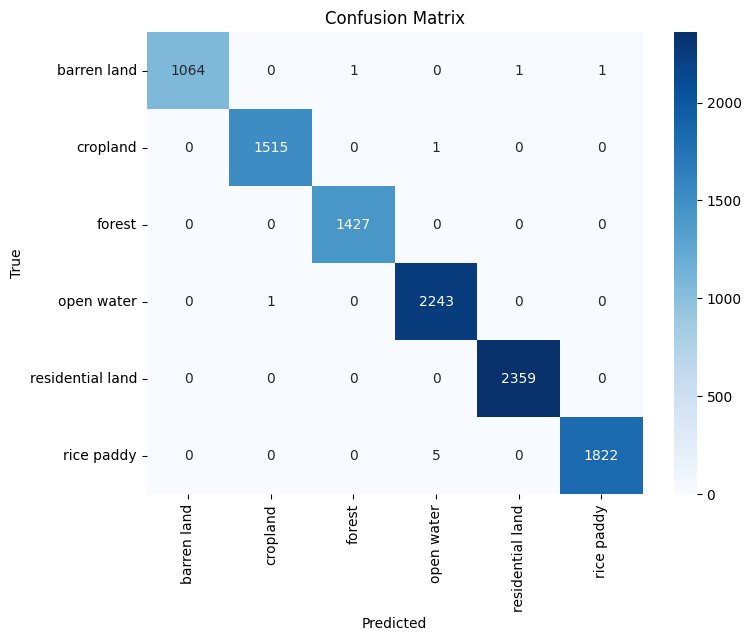

In [10]:
# Đọc dữ liệu huấn luyện
file_path = '/content/ThuyenData.csv'
data = pd.read_csv(file_path)

# Số hóa label
le = LabelEncoder()
data['label'] = le.fit_transform(data['label'])

# Định nghĩa feature và target
X = data[['Long', 'Lat', 'B04', 'B05', 'B06']]
y = data['label']

# Tách tập train và test (nếu cần đánh giá mô hình)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Khởi tạo và huấn luyện mô hình
model = XGBClassifier(objective='multi:softmax', num_class=6, eval_metric='mlogloss')
model.fit(X_train, y_train)

# Đánh giá mô hình
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

# Ma trận nhầm lẫn (nếu cần)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [16]:
# === Phần 2: Tạo bản đồ lớp phủ ===
image_path = "/content/test1-0000000000-0000013312.tif"  # Đường dẫn đến ảnh Sentinel
with rasterio.open(image_path) as src:
    metadata = src.meta.copy()
    prediction_map = np.zeros((src.height, src.width), dtype=np.uint8)

    band_names = ['B04', 'B05', 'B06']
    band_indices = []
    for i, band_name in enumerate(band_names):
        try:
            band_index = src.descriptions.index(band_name) + 1
            band_indices.append(band_index)
        except ValueError:
            band_indices.append(i + 1)
            print(f"Warning: Band {band_name} not found, using band {i+1} instead.")


    for ji, window in src.block_windows(1):  # Lặp qua các block
        try:  # Xử lý ngoại lệ nếu khối không có dữ liệu
            tile = src.read(band_indices, window=window)
            tile = np.transpose(tile, (1, 2, 0))
            height, width, bands = tile.shape

            lons = np.zeros((height, width))
            lats = np.zeros((height, width))
            for i in range(height):
                for j in range(width):
                    lon, lat = src.xy(window.row_off + i, window.col_off + j)
                    lons[i, j] = lon
                    lats[i, j] = lat

            tile_reshaped = np.concatenate([
                lons.reshape(-1, 1),
                lats.reshape(-1, 1),
                tile.reshape(height * width, bands)
            ], axis=1)

            tile_predictions = model.predict(tile_reshaped)
            tile_predictions = tile_predictions.reshape(height, width)
            prediction_map[window.row_off:window.row_off + height,
                          window.col_off:window.col_off + width] = tile_predictions

        except Exception as e:  # Bắt lỗi và in ra thông báo
            print(f"Lỗi khi xử lý khối {ji}: {e}")
            continue


# Lưu bản đồ kết quả
metadata.update({
    "driver": "GTiff",
    "dtype": "uint8",
    "count": 1,
    "nodata": 0
})

with rasterio.open("prediction_map.tif", "w", **metadata) as dst:
    dst.write(prediction_map, 1)

print("Bản đồ lớp phủ đã được lưu vào prediction_map.tif")

Bản đồ lớp phủ đã được lưu vào prediction_map.tif
